In [1]:
import rebound
import reboundx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.animation as animation
%matplotlib inline

In [2]:
from disturb_Qavg_r3bp_helio import Q_averaged_disturb
from eq_points_r3bp_helio_conservative import lpe_r3bp_helio_kappa, root_find

In [3]:
Degree_To_Rad = np.pi/180.
AU_To_Meter = 1.496e11
yr = 365*24*3600 # s
G = 6.6743e-11 # SI units
c_light = 3e8


m_Sun = 1.99e30 # solar mass in [kg]
R_Sun = 6.957e8 # solar radius in [m]
m_J = 1.898e27 # Jupiter mass in [kg]
R_J = 7.1492e7 # Jupiter radius in [m]
a_J = 7.78479e8 # Jupiter semi-major axis in [m]
m_E = 5.9722e24 # Earth mass in [kg]
R_E = 6.371e6 # Earth radius in [m]


k1 = 1.0 # m_star/m_Sun
m_Star = k1 * m_Sun
R_Star = k1 * R_Sun
R_sub = (k1**2) * 4 * R_Sun

k2 = 1.0 # m_planet/m_Jupiter
m_Planet = k2 * m_J

if k2 <= 0.41:
    R_Planet = R_E * (m_Planet/m_E)**(0.59) # low-mass planet; scale with Earth
else:
    R_Planet = R_J * k2**(-0.04) # massive planet; scale with Jupiter

k_ap = 10
a_Planet = k_ap * R_Sun # or R_Sun


In [4]:
beta = 0.1

j, k = 2., 1.
p, q = j-k, k

a1 = a_Planet
a2_res = a1 * ((j/(j-k))**(2/3)) * ((1-beta)**(1/3))
n1 = np.sqrt(G*m_Star/(a1**3))
n2_res = (j-k)*n1/j # np.sqrt(G*m_Star*(1-beta)/(a2_res**3))
mu1 = m_Planet/m_Star/(1-beta)

numerical linearization
--

Lagrange's equations

$R_2 = \frac{Gm_1}{a_2} \sum_{n=1}^{\infty} C_n e_2^n \cos{(n\phi_2)}$

$\frac{d n_2}{dt} = -\frac{3}{a_2^2}\frac{\partial R_2}{\partial \lambda_2} + \frac{n_2}{\tau_{n_2}}\frac{1+\frac{3}{2}e_2^2}{(1-{e_2}^2)^{3/2}}$

$\frac{d e_2}{dt} = -\frac{\sqrt{1-e_2^2}}{n_2a_2^2e_2}(1-\sqrt{1-e_2^2})\frac{\partial R_2}{\partial \lambda_2} - \frac{\sqrt{1-e_2^2}}{n_2a_2^2e_2}\frac{\partial R_2}{\partial \varpi_2} - \frac{e_2}{\tau_{e_2}}\frac{1}{(1-{e_2}^2)^{1/2}}$

$\frac{d\phi_2}{dt} = j(n_2+\dot{\epsilon}_2) - (j-k)n_1 - k\frac{\sqrt{1-e_2^2}}{n_2a_2^2e_2}\frac{\partial R_2}{\partial e_2}$

$\frac{d\epsilon_2}{dt} = -\frac{2}{n_2a_2}\frac{\partial R_2}{\partial a_2} + \frac{\sqrt{1-e_2^2}(1-\sqrt{1-e_2^2})}{n_2a_2^2e_2}\frac{\partial R_2}{\partial e_2}$


In [5]:
def lagrange_equations(p, q, n2, e2, phi2):
    # variables
    a2 = (G*m_Star*(1-beta)/n2**2)**(1/3)
    tau_e2 = 2*a2**2*c_light/(5*G*m_Star*beta)
    tau_n2 = 5/6 * tau_e2
    
    # Q_averaged_disturb(N,p,q,G,m1,m2,a1,a2,e1,e2,phi1,phi2,pomega1)
    R2, dR2da2, dR2de2, dR2dpomega2, dR2dlambda2 = Q_averaged_disturb(2**6, p, q, G, m_Planet, 0.,
                                                              a1, a2, 0., e2, 0., phi2, 0.)
    
    # Lagrange's equations
    dn2dt = -3/a2**2 * dR2dlambda2 + n2/tau_n2 * (1+1.5*e2**2)/(1-e2**2)**(3/2)
    de2dt = -np.sqrt(1-e2**2)/(n2*a2**2*e2)*(1-np.sqrt(1-e2**2))*dR2dlambda2 - np.sqrt(1-e2**2)/(n2*a2**2*e2)*dR2dpomega2 - e2/tau_e2/np.sqrt(1-e2**2)
    depsilondt = -2/n2/a2 * dR2da2 + np.sqrt(1-e2**2)*(1-np.sqrt(1-e2**2))/(n2*a2_res**2*e2) * dR2de2
    dphi2dt = j*(n2+depsilondt) - (j-k)*n1 - k*np.sqrt(1-e2**2)/(n2*a2**2*e2) * dR2de2

    return dn2dt, de2dt, dphi2dt


In [6]:
from scipy.optimize import root

def find_root(x):
        n2, e2, phi2 = x
        dn2dt, de2dt, dphi2dt = lagrange_equations(p, q, n2, e2, phi2)
        return np.array([dn2dt, de2dt, dphi2dt])

guess = [(n2_res, 0.4812, 5.106)]
sol = root(find_root, guess)
n2_eq, e2_eq, phi2_eq = sol.x
print ("n2_eq/n2_res, e2_eq, phi2_eq : ")
print (n2_eq/n2_res, e2_eq, phi2_eq)

n2_eq/n2_res, e2_eq, phi2_eq : 
0.9974293775277104 0.4811868255521742 5.146419749034615


In [7]:
# equilibrium
dn2dt_eq, de2dt_eq, dphi2dt_eq = lagrange_equations(p, q, n2_eq, e2_eq, phi2_eq)
print ("dn2dt_eq, de2dt_eq, dphi2dt_eq : ")
print (dn2dt_eq, de2dt_eq, dphi2dt_eq)

# partial variations around equilibirum
h = 1e-8

d_n2 = n2_eq*h
dn2dt_n2_var, de2dt_n2_var, dphi2dt_n2_var = lagrange_equations(p, q, n2_eq+d_n2, e2_eq, phi2_eq)
dn2dt_n2, de2dt_n2, dphi2dt_n2 = (dn2dt_n2_var-dn2dt_eq)/d_n2, (de2dt_n2_var-de2dt_eq)/d_n2, (dphi2dt_n2_var-dphi2dt_eq)/d_n2
# dn2dt_n2_var, de2dt_n2_var, dphi2dt_n2_var = lagrange_equations(p, q, n2_eq*(), e2_eq, phi2_eq)
# dn2dt_n2, de2dt_n2, dphi2dt_n2 = (dn2dt_n2_var-dn2dt_eq)/h, (de2dt_n2_var-de2dt_eq)/h, (dphi2dt_n2_var-dphi2dt_eq)/h
dn2dt_e2_var, de2dt_e2_var, dphi2dt_e2_var = lagrange_equations(p, q, n2_eq, e2_eq+h, phi2_eq)
dn2dt_e2, de2dt_e2, dphi2dt_e2 = (dn2dt_e2_var-dn2dt_eq)/h, (de2dt_e2_var-de2dt_eq)/h, (dphi2dt_e2_var-dphi2dt_eq)/h
dn2dt_phi2_var, de2dt_phi2_var, dphi2dt_phi2_var = lagrange_equations(p, q, n2_eq, e2_eq, phi2_eq+h)
dn2dt_phi2, de2dt_phi2, dphi2dt_phi2 = (dn2dt_phi2_var-dn2dt_eq)/h, (de2dt_phi2_var-de2dt_eq)/h, (dphi2dt_phi2_var-dphi2dt_eq)/h

A_matrix = np.matrix([[dn2dt_n2, dn2dt_e2, dn2dt_phi2],
                      [de2dt_n2, de2dt_e2, de2dt_phi2],
                      [dphi2dt_n2, dphi2dt_e2, dphi2dt_phi2]])

A_matrix

dn2dt_eq, de2dt_eq, dphi2dt_eq : 
-7.631800117680849e-24 4.332865106371671e-20 -2.607438726889654e-19


matrix([[-3.31907543e-08, -1.97028964e-13, -6.52571684e-13],
        [ 7.66383776e-04,  2.46418396e-09,  1.50680368e-08],
        [ 2.00397211e+00, -1.31026472e-07,  2.94053426e-08]])

In [8]:
eigenvalues, eigenvectors = np.linalg.eig(A_matrix)

In [9]:
eigenvalues

array([ 3.80330319e-10+1.14406158e-06j,  3.80330319e-10-1.14406158e-06j,
       -2.08188836e-09+0.00000000e+00j])

In [10]:
gamma = np.real(eigenvalues[1])
print ("growth rate = ", gamma)

growth rate =  3.803303193676848e-10


rebound
--

In [11]:
sim = rebound.Simulation()
sim.integrator = "ias15"
sim.G = 6.674e-11 # SI units
sim.dt = 1.e2 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally

sim.add(m = m_Star, r = R_sub, hash = "Star")
sim.add(m = m_Planet, a = a_Planet, e = 0, r = R_Planet, hash = "Planet")
# sim.move_to_hel()
sim.move_to_com()

ps = sim.particles
n_p = ps['Planet'].n

sim.status()

---------------------------------
REBOUND version:     	3.24.0
REBOUND built on:    	Mar 28 2023 02:54:30
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	100.000000
---------------------------------
<rebound.particle.Particle object at 0x7fd1417845c0, m=1.99e+30 x=-6629047.270492766 y=0.0 z=0.0 vx=0.0 vy=-131.71788839324768 vz=0.0>
<rebound.particle.Particle object at 0x7fd141784ac0, m=1.898e+27 x=6950370952.729507 y=0.0 z=0.0 vx=0.0 vy=138102.52787279393 vz=0.0>
---------------------------------


collision function setup
--

In [12]:
hash_Star = str(ps['Star'].hash)
hash_Planet = str(ps['Planet'].hash)

ps_sub = []
ps_pl = []

                  
def collision_function(sim_pointer, collision):
    simcontps = sim_pointer.contents.particles # get simulation object from pointer
    hash_p1 = str(simcontps[collision.p1].hash)
    hash_p2 = str(simcontps[collision.p2].hash)
    
    # p1 not dust              
    if hash_p1 == hash_Star:
        ps_sub.append(hash_p2)
        print ('Sublimation:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                 
    elif hash_p1 == hash_Planet:
        ps_pl.append(hash_p2)
        print ('Hit the Planet:', hash_p2, 'at %.5f'%(sim.t/yr), '[yr]')
        j = 2 # remove p2 (dust)
                  
    # p1 is dust  
    else:
        if hash_p2 == hash_Star:
            ps_sub.append(hash_p1)
            print ('Sublimation:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)
        else:
            ps_pl.append(hash_p1)
            print ('Hit the Planet:', hash_p1, 'at %.5f'%(sim.t/yr), '[yr]')
            j = 1 # remove p1 (dust)

    return j                            


sim.collision = "direct"
sim.collision_resolve = collision_function

set up reboundx and radiation force & PR-drag force
--

In [13]:
rebx = reboundx.Extras(sim)
rf = rebx.load_force("radiation_forces")
rebx.add_force(rf)
rf.params["c"] = 3.e8

In [14]:
ps["Star"].params["radiation_source"] = 1 # set 'Star' to be the source of radiation

In [15]:
a_res = a1 * ((j/(j-k))**(2/3)) * ((1-beta)**(1/3))

a = 1.01 * a_Planet * (2**(2/3)) * ((1-beta)**(1/3)) # 3*a_Planet
e = 0
inc = 0 # [degree]

Ndust = 1


for i in range(2, Ndust+2):
#     a = amin + awidth*random.random() # Semimajor axis
    pomega = 2*np.pi*np.random.rand()   # Longitude of pericenter
    f = 2*np.pi*np.random.rand()        # True anomaly
    Omega = 2*np.pi*np.random.rand()    # Longitude of node
#     inc = incmax*np.random.rand()     # Inclination

    sim.add(a=a, e=e, inc=inc*Degree_To_Rad, Omega=Omega, pomega=pomega, f=f) # fake add to obtain Cartesian coords
    xi, yi, zi = ps[i].x, ps[i].y, ps[i].z
    vxi, vyi, vzi = np.sqrt(1-beta)*ps[i].vx, np.sqrt(1-beta)*ps[i].vy, np.sqrt(1-beta)*ps[i].vz # modify v in order for a circular orbit
    sim.remove(i)
    sim.add(x = xi, y = yi, z = zi, vx = vxi, vy = vyi, vz = vzi, hash=i) # real add
    ps[i].params["beta"] = beta

Start Integration
--

In [16]:
# pick out dusts that have been ejected out

# PE + KE wrt Star
def get_E(sim, ps_i):
    rstar = np.array(ps['Star'].xyz)
    r = np.array(ps_i.xyz)
    v = np.array(ps_i.vxyz)
    
    KE = 0.5 * v@v # test particle kinetic energy
    mu = sim.G * ps['Star'].m
    r_ds = r - rstar
    PE = -mu/np.sqrt(r_ds@r_ds) # test particle potential energy
    
    E = KE + PE
    
    return E

In [17]:
%%time

yr = 365*24*3600 # s

Noutput = 5000
times = np.linspace(0*yr, 120*yr, Noutput)

N_d = np.zeros(Noutput)

xyzs = []
vxyzs = []
ps_ej = []

EA_p, l_p, resonant_angle_p = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
e_d, a_d, n_d, kappa, resonant_angle_d = np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)
pomega_p, pomega_d, f_p, f_d, Omega_d, omega_d =  np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput), np.zeros(Noutput)

for i, time in enumerate(times):
    sim.integrate(time)
    if sim.N == 2:
        print ('  ---------------------------------------\n',
               '|                                       |\n',
               '| No dusts left. Finish integration. :) |\n',
               '|                                       |\n',
               ' ---------------------------------------')
        break    

    
    N_d[i] = sim.N-2
    
    xyzs.append([ps[j].xyz for j in range(sim.N)])
    vxyzs.append([ps[j].vxyz for j in range(sim.N)])
    
    ps["Star"].m = m_Star*(1-beta)
    
    mu1 = sim.G * ps['Star'].m
    mu2 = sim.G * ps['Planet'].m
    
    l_p[i] = ps["Planet"].l
    EA_p[i] = np.arccos(ps["Planet"].x/ps["Planet"].a)
    e_d[i], a_d[i], n_d[i] = ps[2].e, ps[2].a, ps[2].n
    pomega_p[i], pomega_d[i], Omega_d[i], omega_d[i] = ps['Planet'].pomega, ps[2].pomega, ps[2].Omega, ps[2].omega
    f_p[i], f_d[i] = ps['Planet'].f, ps[2].f
    resonant_angle_p[i] = 2*ps[2].l -  ps['Planet'].l - ps['Planet'].pomega
    resonant_angle_d[i] = 2*ps[2].l -  ps['Planet'].l - ps[2].pomega    
    kappa[i] = ps[2].a/a_res * (2*np.sqrt(1-ps[2].e**2)-1)**2 -1

    ps["Star"].m = m_Star                                

    
    # ejection judgement
    
    E_ps_array = []
    for j in range(2, sim.N):
        E_ps_array.append(get_E(sim, ps[j]))
    
    index_ej = np.where(np.array(E_ps_array)>0)[0] + 2
    
    l = 0 # count of dusts already removed in this round
    for k in range(len(index_ej)):
        ps_ej.append(str(ps[int(index_ej[k])-l].hash))
        print ('Ejection:', str(ps[int(index_ej[k])-l].hash), 'at %.5f'%(sim.t/yr), '[yr]')
        sim.remove(int(index_ej[k])-l)
        l += 1


Hit the Planet: c_uint(2) at 119.98325 [yr]
  ---------------------------------------
 |                                       |
 | No dusts left. Finish integration. :) |
 |                                       |
  ---------------------------------------
CPU times: user 5.65 s, sys: 47.7 ms, total: 5.7 s
Wall time: 5.87 s


growth rate
--

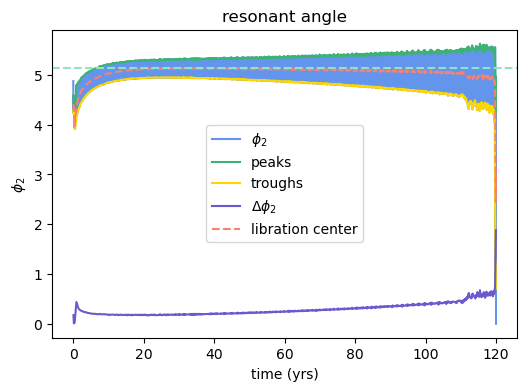

In [18]:
phi2_num = resonant_angle_d%(2*np.pi)

from scipy.signal import find_peaks
peaks, _ = find_peaks(phi2_num) # distance=10
troughs, _ = find_peaks(-phi2_num)
peak_phi2 = phi2_num[peaks]
trough_phi2 = phi2_num[troughs]

# calculate the libration amplitude over time
libration_amplitude, libration_center = [], []
amplitude_time = []

for i in range(min(len(peaks), len(troughs))):
    libration_amplitude.append((peak_phi2[i] - trough_phi2[i]) / 2)
    libration_center.append((peak_phi2[i] + trough_phi2[i]) / 2)
    amplitude_time.append(times[peaks[i]])


fig = plt.figure(figsize=(6, 4))
ax = plt.subplot(111)
plt.title("resonant angle")
ax.set_xlabel("time (yrs)")
ax.set_ylabel(r"$\phi_2$")
plt.plot(times/yr, phi2_num, color = 'cornflowerblue', label=r'$\phi_2$')
plt.plot(times[peaks]/yr, phi2_num[peaks], c='mediumseagreen', label='peaks')
plt.plot(times[troughs]/yr, phi2_num[troughs], c='gold', label='troughs')
plt.plot(np.array(amplitude_time)/yr, libration_amplitude, c='slateblue', label=r'$\Delta\phi_2$')
plt.plot(np.array(amplitude_time)/yr, libration_center, c='salmon', ls='--', label='libration center')
ax.axhline(y=phi2_eq, c='#90e4c1', ls='--')
plt.legend()
plt.show()

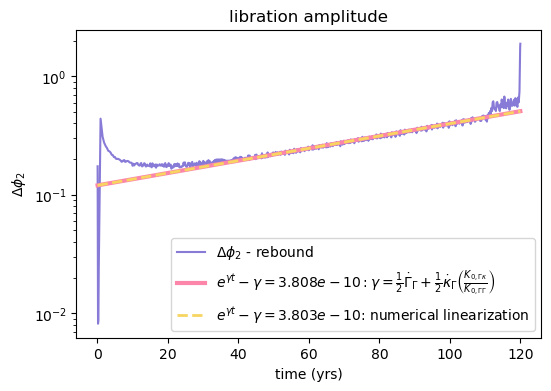

In [19]:
t_array = times[peaks]
y_numerical = np.exp(gamma*t_array)
y_analytical = np.exp(3.80847469070978e-10*t_array) # see growth rate - analytical.ipynb

fig = plt.figure(figsize=(6,4))
ax = plt.subplot(111)
# ax.set_xlim([-2.5,300])
# ax.set_ylim([0,6.28])
plt.title("libration amplitude")
plt.xlabel("time (yrs)")
plt.ylabel(r'$\Delta\phi_2$')
plt.yscale("log")
plt.plot(np.array(amplitude_time)/yr, libration_amplitude, c='slateblue', alpha=0.8, label=r'$\Delta\phi_2$ - rebound')
plt.plot(times[peaks]/yr, 0.12*y_analytical, c='#fc86aa', lw=3, ls='-', label=r'$e^{\gamma t} - \gamma = 3.808e-10 : \gamma = \frac{1}{2}\dot{\Gamma}_{\Gamma} + \frac{1}{2}\dot{\kappa}_{\Gamma}\left(\frac{K_{0,\Gamma\kappa}}{K_{0,\Gamma\Gamma}}\right)$')
plt.plot(times[peaks]/yr, 0.12*y_numerical, c='#f7d560', lw=2, ls='--', label=r'$e^{\gamma t} - \gamma = 3.803e-10$: numerical linearization')

plt.legend()
plt.show()